In [ ]:
%load_ext autoreload
%autoreload 2
import os
import matplotlib.pyplot as plt
import seaborn as sns
from os.path import join
from tqdm import tqdm
import pandas as pd
import sys
from typing import List
import numpy as np
from copy import deepcopy
import joblib
from pprint import pprint
from sklearn.preprocessing import normalize
from math import ceil
import cortex
from neuro.config import repo_dir, PROCESSED_DIR, setup_freesurfer
from collections import defaultdict
from scipy.stats import norm
from statsmodels.stats.multitest import multipletests
import gemv
from neuro.flatmaps_helper import load_flatmaps
import sasc.viz
from neuro import analyze_helper
import nibabel as nib
neurosynth_compare = __import__('04_neurosynth_compare')
import neurosynth
from neuro.features.questions.gpt4 import QS_35_STABLE
setup_freesurfer()

# subject = 'S02'
# subjects = [f'S0{i}' for i in range(1, 9) if not i == 6] # there's some problem with S06 surf2surf
subjects = ['S01', 'S02', 'S03']

In [ ]:
qs = QS_35_STABLE
ndel = 8
subjects = ['S01', 'S02', 'S03']
plt.figure(figsize=(len(subjects) * 4, 3), dpi=300)
for subject in subjects:
    flatmaps_qa_dict = joblib.load(
        join(PROCESSED_DIR, subject.replace('UT', ''),
             f'individual_gpt4_ndel={ndel}_pc_new_all_delays.pkl').replace('_ndel=16', 'ndel=16'))

    corrs = joblib.load(
        join(PROCESSED_DIR, subject.replace('UT', ''),
             f'corrs_test_individual_gpt4_qs_35_ndel={ndel}_pc_new.pkl').replace('_ndel=16', 'ndel=16'))
    print('test corr', np.mean([np.mean(c) for c in corrs.values()]))

    plt.subplot(1, len(subjects), 1 + subjects.index(subject))
    for q in QS_35_STABLE:
        vals = flatmaps_qa_dict[q]
        vals = vals[:, corrs[q] > 0.1]
        avg_timecourse = np.abs(vals).mean(axis=1)
        plt.plot(avg_timecourse)
    plt.title(subject)
    plt.xticks(np.arange(len(avg_timecourse)), labels=[
               'TR-' + str(x) for x in np.arange(1, len(avg_timecourse) + 1)])
    plt.tight_layout()
    if subject == 'S01':
        plt.ylabel('Avg. abs. coef weight')
plt.show()

# TR time

In [ ]:
qs = QS_35_STABLE
ndel = 8
# subjects = ['S01', 'S02', 'S03']
subjects = [f'S0{i}' for i in range(1, 9)]
avg_time_delay_dict = defaultdict(list)
plt.figure(figsize=(len(subjects) * 4, 3), dpi=300)
for subject in subjects:
    flatmaps_qa_dict = joblib.load(
        join(PROCESSED_DIR, subject.replace('UT', ''),
             f'individual_gpt4_ndel={ndel}_pc_new_all_delays.pkl').replace('_ndel=16', 'ndel=16').replace('_ndel=4', ''))

    corrs = joblib.load(
        join(PROCESSED_DIR, subject.replace('UT', ''),
             f'corrs_test_individual_gpt4_qs_35_ndel={ndel}_pc_new.pkl').replace('_ndel=16', 'ndel=16').replace('_ndel=4', ''))
    print('test corr', np.mean([np.mean(c) for c in corrs.values()]))

    for q in QS_35_STABLE:
        vals = flatmaps_qa_dict[q]
        vals = vals[:, corrs[q] > 0.1]
        v = np.arange(1, len(vals) + 1).reshape(1, -1)
        w = np.abs(vals)
        w = normalize(w, axis=0, norm='l1')
        avg_time_delay = np.mean(v @ w)
        avg_time_delay_dict[subject].append(avg_time_delay)

In [ ]:
d = pd.DataFrame(avg_time_delay_dict,
                 index=analyze_helper.abbrev_questions(QS_35_STABLE))
# add mean col
d['AVG'] = d.mean(axis=1)
d = d.sort_values(by='AVG', ascending=False)
plt.figure(figsize=(10, 10), dpi=300)
sns.heatmap(d, cmap='Reds', annot=True)
plt.title(f'Avg. time delay (weighted by abs. enc. weight in {ndel} TRs)')
plt.show()

# Timing flatmaps

In [ ]:
qs = QS_35_STABLE
ndel = 8
subjects = ['S01', 'S02', 'S03']
for subject in subjects:
    flatmaps_qa_dict = joblib.load(
        join(PROCESSED_DIR, subject.replace('UT', ''),
             f'individual_gpt4_ndel={ndel}_pc_new_all_delays.pkl').replace('_ndel=16', 'ndel=16'))

    corrs = joblib.load(
        join(PROCESSED_DIR, subject.replace('UT', ''),
             f'corrs_test_35.pkl').replace('_ndel=16', 'ndel=16')).values[0]
    # print('test corr', np.mean([np.mean(c) for c in corrs.values()]))
    for q in QS_35_STABLE:
        vals = flatmaps_qa_dict[q]
        vals = vals[:, corrs > 0.1]
        v = np.arange(1, len(vals) + 1).reshape(1, -1)
        w = np.abs(vals)
        w = normalize(w, axis=0, norm='l1')
        time_delays = v @ w
        # fill with nans
        flatmap = np.full_like(corrs, np.nan)
        flatmap[corrs > 0.1] = time_delays.flatten()
    sasc.viz.quickshow(flatmap, fname_save=join(
        'timescales', f'{subject}_timescales.png'), cmap='Reds', subject='UT' + subject, cmap_perc_to_hide=0.1)

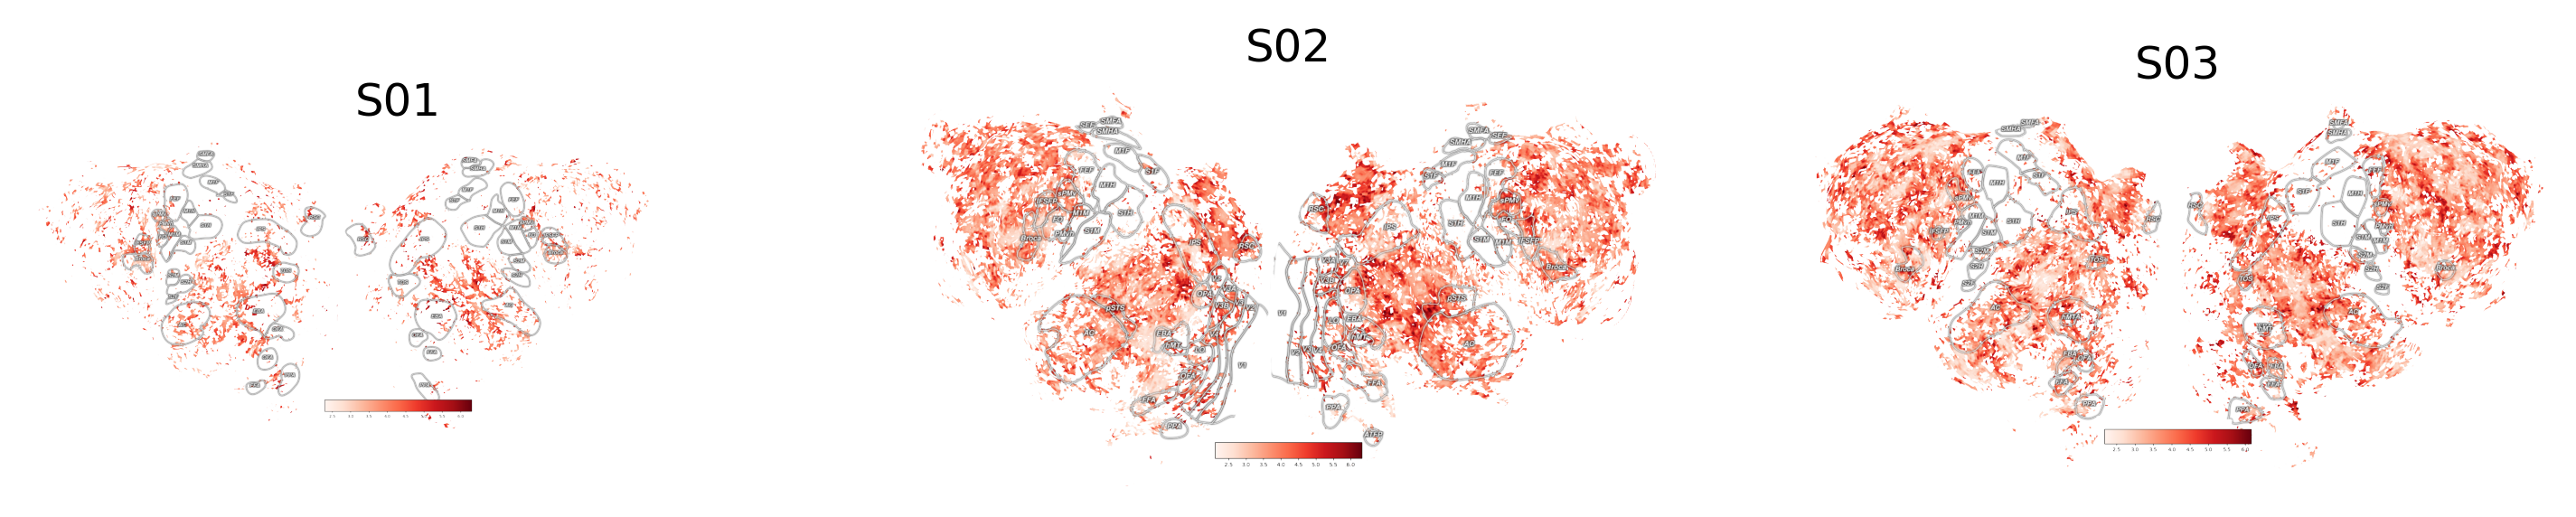

In [ ]:
# read the 3 images and show in a row
from matplotlib.image import imread
subjects = ['S01', 'S02', 'S03']
plt.figure(figsize=(len(subjects) * 4, 3), dpi=300)
for subject in subjects:
    img = imread(join('timescales', f'{subject}_timescales.png'))
    plt.subplot(1, len(subjects), 1 + subjects.index(subject))
    plt.imshow(img)
    plt.title(subject)
    plt.axis('off')